# Analysis of MCTS Crystal Optimization


**Our goals are:**
1. Load the simulation data (`dumpfile.dat`).
2. Visualize the convergence (how quickly we found stable structures).
3. Extract the best crystal structures as `POSCAR` files for visualization.

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp import Poscar
from Perturb import gel_latt_coords

# --- Configuration ---
DUMP_FILE = "dumpfile.dat"       # MCTS output file
OUTPUT_DIR = "best_structures"   # Folder to save resulting structures
TOP_N = 1                      # How many structures to save

### 2. Load Simulation Data
Read the `dumpfile.dat` file, which contains every structure evaluated during the search. We'll load this into a standard data table (DataFrame) for easy analysis.

In [4]:
data_list = []

if not os.path.exists(DUMP_FILE):
    print(f"Error: {DUMP_FILE} not found!")
else:
    print(f"Reading {DUMP_FILE}...")
    with open(DUMP_FILE, "r") as infile:
        for i, line in enumerate(infile):
            try:
                # Format: parameters | species | energy
                col = line.split("|")
                if len(col) < 3: continue
                
                energy = float(col[2])
                
                # Filter out failed calculations (NaN/Inf)
                if math.isnan(energy) or math.isinf(energy):
                    continue
                
                data_list.append({
                    "id": i + 1,
                    "parameters": np.array([float(v) for v in col[0].split()]),
                    "species": col[1].split(),
                    "energy": energy
                })
            except Exception:
                continue

    df = pd.DataFrame(data_list)
    print(f"Loaded {len(df)} valid evaluations.")
    display(df.head())

Reading dumpfile.dat...
Loaded 19842 valid evaluations.


,id,parameters,species,energy
0,1,"[6.156642, 6.376881430470227, 6.57720592844742...","[Si, Si, Si, Si, Si, Si, Si, Si]",-3.722428
1,2,"[6.044433, 6.511712403469997, 6.52819537291662...","[Si, Si, Si, Si, Si, Si, Si, Si]",-3.528677
2,3,"[5.986341, 6.224432452181484, 7.00000030854670...","[Si, Si, Si, Si, Si, Si, Si, Si]",-3.527449
3,4,"[5.723498, 5.941992502943856, 6.26593820981072...","[Si, Si, Si, Si, Si, Si, Si, Si]",-3.791560
4,5,"[5.926937, 6.166591980895201, 6.00314989207582...","[Si, Si, Si, Si, Si, Si, Si, Si]",-3.799726


### 3. Plot Optimization History
We want to see the **best energy found so far** as the simulation progressed. A steep drop indicates the algorithm successfully learned and improved the structure.

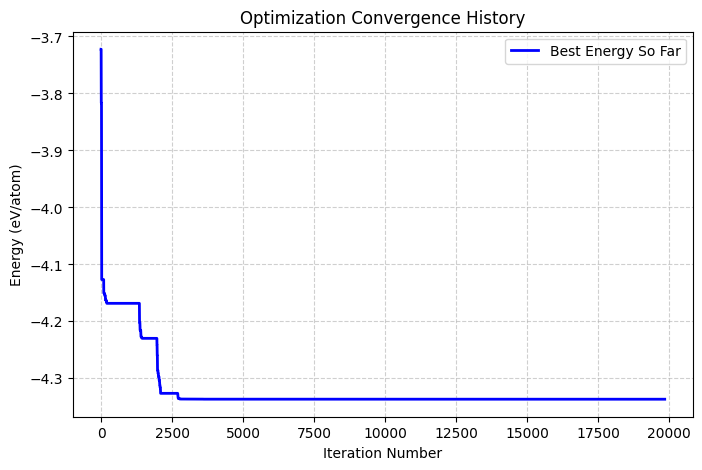

Lowest Energy Found: -4.3366 eV/atom


In [5]:
if not df.empty:
    # Calculate the cumulative minimum (best score seen up to step N)
    df['min_energy_so_far'] = df['energy'].cummin()
    
    # Plot setup
    plt.figure(figsize=(8, 5))
    plt.plot(df.index, df['min_energy_so_far'], color='blue', linewidth=2, label='Best Energy So Far')
    
    # Labels and Style
    plt.xlabel("Iteration Number")
    plt.ylabel("Energy (eV/atom)")
    plt.title("Optimization Convergence History")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plt.savefig("convergence_plot.png", dpi=300)
    plt.show()
    
    print(f"Lowest Energy Found: {df['energy'].min():.4f} eV/atom")
else:
    print("No data to plot.")

### 4. Extract Best Structures
Finally, we take the top results and save them as VASP `POSCAR` files. You can open these files in tools like VESTA or OVITO to visualize the atomic structure.

In [6]:
if not df.empty:
    # Sort structures by lowest energy
    df_sorted = df.sort_values(by="energy").reset_index(drop=True)

    if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)

    print(f"Saving top {TOP_N} structures to '{OUTPUT_DIR}/'...")

    for i in range(min(TOP_N, len(df_sorted))):
        row = df_sorted.iloc[i]
        
        # 1. Reconstruct Geometry
        latt_params, coords = gel_latt_coords(row['parameters'])
        
        # 2. Create Pymatgen Structure
        try:
            lattice = Lattice.from_parameters(
                a=latt_params[0], b=latt_params[1], c=latt_params[2],
                alpha=latt_params[3], beta=latt_params[4], gamma=latt_params[5]
            )
            struct = Structure(lattice, row['species'], coords, to_unit_cell=True)

            # 3. Save File
            filename = f"{OUTPUT_DIR}/rank_{i}_E_{row['energy']:.4f}.POSCAR"
            Poscar(struct).write_file(filename)
            print(f"  Saved: {filename}")
            
        except Exception as e:
            print(f"  Skipped rank {i} due to geometry error.")

    print("\nDone! Check the output folder.")

Saving top 1 structures to 'best_structures/'...
  Saved: best_structures/rank_0_E_-4.3366.POSCAR

Done! Check the output folder.


### 5. Compare with Reference Structure (`ref.geo`)
We will now compare the lattice parameters ($a, b, c$) and angles ($\alpha, \beta, \gamma$) of our **best optimized structure** against a known reference structure (`ref.geo`). 

**Note:** Ensure `ref.geo` is in the same directory and is in LAMMPS data format.

Loading reference from ref.geo...


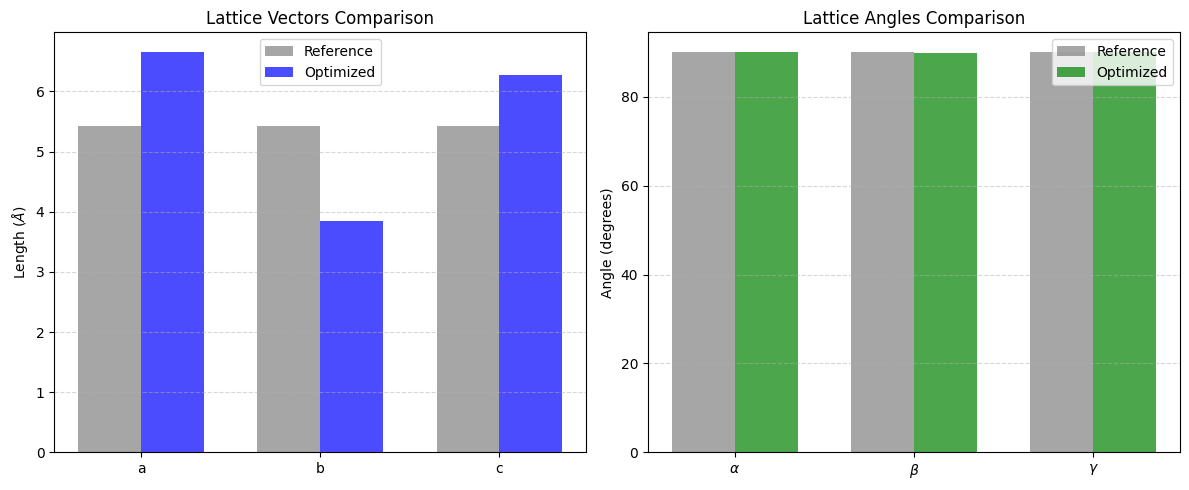

Metric     | Reference  | Optimized  | Diff      
----------------------------------------------
a          | 5.4310     | 6.6511     | 1.2201    
b          | 5.4310     | 3.8402     | -1.5907   
c          | 5.4310     | 6.2717     | 0.8407    
alpha      | 90.0000    | 89.9898    | -0.0102   
beta       | 90.0000    | 89.9606    | -0.0394   
gamma      | 90.0000    | 89.9958    | -0.0042   


In [7]:
from pymatgen.io.lammps.data import LammpsData

REF_FILE = "ref.geo"

if not df.empty and os.path.exists(REF_FILE):
    # --- 1. Load Reference Structure ---
    print(f"Loading reference from {REF_FILE}...")
    try:
        # Assuming atom_style is 'atomic' or 'full'; adjust if necessary
        ref_lammps = LammpsData.from_file(REF_FILE, atom_style="atomic")
        ref_struct = ref_lammps.structure
        ref_latt = ref_struct.lattice
    except Exception as e:
        print(f"Error loading ref.geo: {e}")
        ref_latt = None

    # --- 2. Get Best Optimized Structure ---
    # Sort to ensure we have the absolute best
    df_sorted = df.sort_values(by="energy").reset_index(drop=True)
    best_row = df_sorted.iloc[0]
    
    # Reconstruct lattice from flat parameters
    opt_latt_p, _ = gel_latt_coords(best_row['parameters'])
    opt_latt = Lattice.from_parameters(*opt_latt_p)

    if ref_latt:
        # --- 3. Prepare Data for Plotting ---
        labels = ['Reference', 'Optimized']
        
        # Lattice Vectors (a, b, c)
        ref_abc = [ref_latt.a, ref_latt.b, ref_latt.c]
        opt_abc = [opt_latt.a, opt_latt.b, opt_latt.c]
        
        # Lattice Angles (alpha, beta, gamma)
        ref_ang = [ref_latt.alpha, ref_latt.beta, ref_latt.gamma]
        opt_ang = [opt_latt.alpha, opt_latt.beta, opt_latt.gamma]

        # --- 4. Create Bar Plots ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot 1: Lattice Vectors
        x = np.arange(3)
        width = 0.35
        
        axes[0].bar(x - width/2, ref_abc, width, label='Reference', color='gray', alpha=0.7)
        axes[0].bar(x + width/2, opt_abc, width, label='Optimized', color='blue', alpha=0.7)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(['a', 'b', 'c'])
        axes[0].set_ylabel("Length ($\AA$)")
        axes[0].set_title("Lattice Vectors Comparison")
        axes[0].legend()
        axes[0].grid(axis='y', linestyle='--', alpha=0.5)

        # Plot 2: Lattice Angles
        axes[1].bar(x - width/2, ref_ang, width, label='Reference', color='gray', alpha=0.7)
        axes[1].bar(x + width/2, opt_ang, width, label='Optimized', color='green', alpha=0.7)
        axes[1].set_xticks(x)
        axes[1].set_xticklabels([r'$\alpha$', r'$\beta$', r'$\gamma$'])
        axes[1].set_ylabel("Angle (degrees)")
        axes[1].set_title("Lattice Angles Comparison")
        axes[1].legend()
        axes[1].grid(axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig("lattice_comparison.png", dpi=300)
        plt.show()
        
        # Print numerical comparison
        print(f"{'Metric':<10} | {'Reference':<10} | {'Optimized':<10} | {'Diff':<10}")
        print("-" * 46)
        for name, r_val, o_val in zip(['a', 'b', 'c'], ref_abc, opt_abc):
            print(f"{name:<10} | {r_val:<10.4f} | {o_val:<10.4f} | {o_val-r_val:<10.4f}")
        for name, r_val, o_val in zip(['alpha', 'beta', 'gamma'], ref_ang, opt_ang):
            print(f"{name:<10} | {r_val:<10.4f} | {o_val:<10.4f} | {o_val-r_val:<10.4f}")

    else:
        print("Could not compare: Reference structure not loaded.")
else:
    print("Reference file 'ref.geo' not found or no optimization data available.")

### 6. Visualizing Atomic Structures with ASE

In this step, we will:
**Visualize** the structures interactively within the notebook using `ase.visualize.view`.

In [9]:
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
from ase import Atoms
import numpy as np

# Ensure we have the necessary data from the previous steps
if 'ref_struct' in locals() and not df.empty:
    
    # --- 1. Reconstruct the Full Optimized Structure ---
    # We need to rebuild the full Pymatgen object for the best result found
    df_sorted = df.sort_values(by="energy").reset_index(drop=True)
    best_row = df_sorted.iloc[0]
    
    # Extract params using your helper function
    opt_params, opt_coords = gel_latt_coords(best_row['parameters'])
    
    # Rebuild the Pymatgen Structure
    opt_lattice = Lattice.from_parameters(
        a=opt_params[0], b=opt_params[1], c=opt_params[2],
        alpha=opt_params[3], beta=opt_params[4], gamma=opt_params[5]
    )
    
    opt_struct = Structure(
        opt_lattice, 
        best_row['species'], 
        opt_coords, 
        to_unit_cell=True
    )

    # --- 2. Convert Pymatgen Structures to ASE Atoms Objects ---
    ref_atoms = AseAtomsAdaptor.get_atoms(ref_struct)
    opt_atoms = AseAtomsAdaptor.get_atoms(opt_struct)

    # --- 3. Visualize ---
    print(f"Visualizing Best Optimized Structure (E={best_row['energy']:.4f} eV)...")
    
    # FIX: The 'x3d' viewer only supports one structure at a time.
    # We pass only 'opt_atoms' to prevent the AttributeError.
    view(opt_atoms, viewer='x3d')

else:
    print("Data missing: Please run the analysis and loading steps above first.")

Visualizing Best Optimized Structure (E=-4.3366 eV)...


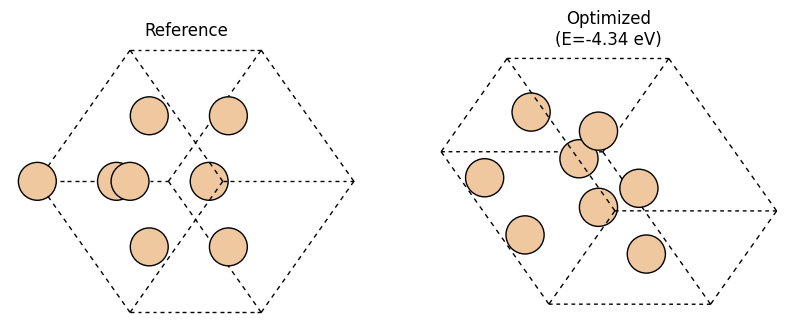

In [10]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

# Create a static side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot Reference
plot_atoms(ref_atoms, ax[0], radii=0.5, rotation=('45x,45y,0z'))
ax[0].set_title("Reference")
ax[0].axis('off')

# Plot Optimized
plot_atoms(opt_atoms, ax[1], radii=0.5, rotation=('45x,45y,0z'))
ax[1].set_title(f"Optimized\n(E={best_row['energy']:.2f} eV)")
ax[1].axis('off')

plt.show()